# Visualization of College Data



- Is there a correlation between test scores and admissions rates?
- 

## Imports

import sys
print(sys.version) # making sure we're on the right conda env

In [30]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # general plotting
import matplotlib as mpl # for figure quality (dpi)
import os
import math

## Formatting

In [3]:
# Fontsize
fs = 12

# Figure quality
mpl.rcParams['figure.dpi']= 100 # in notebook resolution
mpl.rc("savefig", dpi=400) # higher resolution when saving

# Set font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# Set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']= 1
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

## Image folder for storing plots

In [4]:
# Create directory if doesn't already exist
img_directory = './images/plots'
if not os.path.exists(img_directory):
    os.mkdir(img_directory)
    print("Directory: " , img_directory ,  " created.")

## Connect to College database 

In [5]:
mydb = mysql.connector.connect(
    host='localhost',
    user='root',
    passwd='pR0Gr@m4j3sU5',
    auth_plugin='mysql_native_password',
    database='College') 

Database cursor 

In [6]:
mycursor = mydb.cursor()

Show tables in the IMDb database by executing the simple statement

In [6]:
mycursor.execute("SHOW TABLES;")

In [7]:
#tables = mycursor.fetchall()

In [10]:
print('College Database contains the following tables:')
print('--------------------------------------------')
for table in mycursor:
    print(table)

IMDb Database contains the following tables:
--------------------------------------------


## Is there a correlation between test scores and admissions rates?

Let's take our query and graph it

In [9]:
Query1 = """select inst_name, act_midpoint, sat_avg, adm_rate from universities 
as u join test_scores as t on u.unit_id = t.unit_id;"""
#where adm_rate is not null and act_midpoint is not null and sat_avg is not null;"""

In [10]:
mycursor.execute(Query1)

In [11]:
df = pd.DataFrame(mycursor,columns=['inst_name','act_midpoint', 'sat_avg', 'adm_rate'])

In [12]:
df.head()

,inst_name,act_midpoint,sat_avg,adm_rate
0,Alabama A & M University,17.0,939.0,0.9175
1,University of Alabama at Birmingham,26.0,1234.0,0.7366
2,Amridge University,NaN,NaN,NaN
3,University of Alabama in Huntsville,28.0,1319.0,0.8257
4,Alabama State University,17.0,946.0,0.9690


Text(0.5, 1.0, 'ACT Score vs Admit Rate')

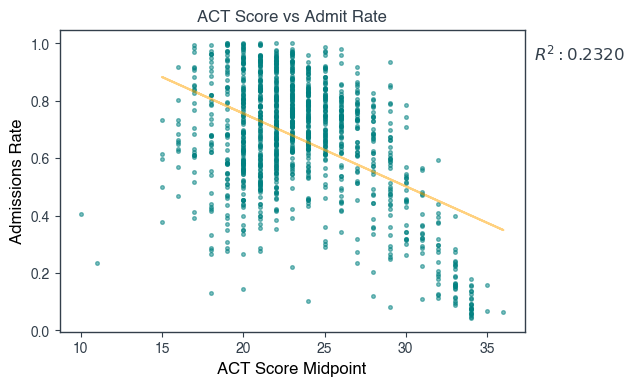

In [13]:
x = df['act_midpoint']
y = df['adm_rate']
plt.scatter(x, y, s=7, c='teal', alpha=0.5)

df1 = df[df.act_midpoint > 14] #remove the outliers
x = df1['act_midpoint']
y = df1['adm_rate']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, c='orange', alpha=0.5)

corr_matrix = np.corrcoef(x, y)
r2 = corr_matrix[0,1] ** 2
plt.annotate(f'$R^{2}: {r2:.4f}$', xy=(1.02,.9),xycoords='axes fraction',
             fontsize=fs)

plt.xlabel('ACT Score Midpoint', fontsize=fs)
plt.ylabel('Admissions Rate', fontsize=fs)
plt.title('ACT Score vs Admit Rate', fontsize=fs)

Text(0.5, 1.0, 'SAT Score vs Admit Rate')

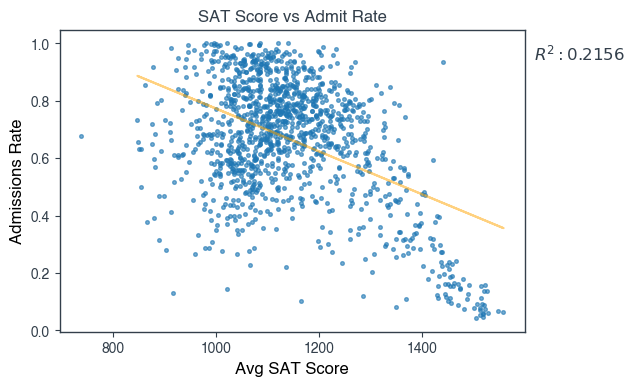

In [14]:
x = df['sat_avg']
y = df['adm_rate']
plt.scatter(x, y, s=7, alpha=0.6)

df1 = df[df.sat_avg > 800] #remove the outlier
x = df1['sat_avg']
y = df1['adm_rate']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, c='orange', alpha=0.5)

corr_matrix = np.corrcoef(x, y)
r2 = corr_matrix[0,1] ** 2
plt.annotate(f'$R^{2}: {r2:.4f}$', xy=(1.02,.9),xycoords='axes fraction',
             fontsize=fs)

plt.xlabel('Avg SAT Score', fontsize=fs)
plt.ylabel('Admissions Rate', fontsize=fs)
plt.title('SAT Score vs Admit Rate', fontsize=fs)

If we zoom in at the most "elite" schools (high test score + low adm rate), however, the correlation is no longer as clear. (see the ACT scores 34 and above, and the below graph)

(1475.0, 1600.0)

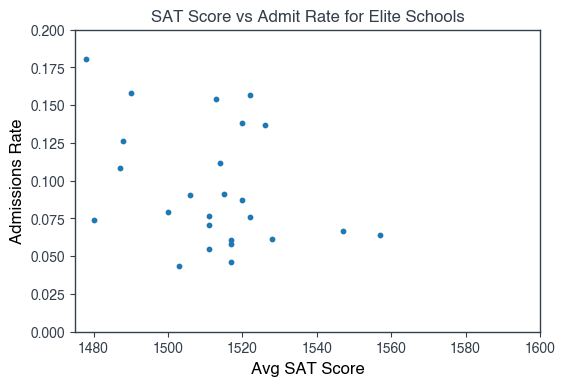

In [53]:
ax = plt.gca()

plt.scatter(df['sat_avg'], df['adm_rate'], s=10, alpha=1)
plt.xlabel('Avg SAT Score', fontsize=fs)
plt.ylabel('Admissions Rate', fontsize=fs)
plt.title('SAT Score vs Admit Rate for "Elite" Schools', fontsize=fs)
ax.set_ylim([0, 0.2])
ax.set_xlim([1475, 1600])

There's one more quirk worth looking at, and that's the very competitive schools with low test scores:

In [90]:
Query2 = """select inst_name, sat_avg, adm_rate from universities 
as u join test_scores as t on u.unit_id = t.unit_id
where adm_rate <= 0.15 and sat_avg is not null order by sat_avg;"""
mycursor.execute(Query2)
df = pd.DataFrame(mycursor, columns=["inst_name", "sat_avg", "adm_rate"])
df.head(10)

,inst_name,sat_avg,adm_rate
0,Dallas Christian College,917.0,0.1305
1,Ottawa University-Ottawa,1020.0,0.1454
2,College of the Ozarks,1164.0,0.1026
3,United States Military Academy,1284.0,0.1203
4,United States Naval Academy,1348.0,0.0833
5,United States Air Force Academy,1368.0,0.1108
6,University of California-Los Angeles,1429.0,0.1232
7,Amherst College,1431.0,0.1131
8,Tulane University of Louisiana,1444.0,0.1287
9,Barnard College,1445.0,0.1177


Notable results are the US Military Academies and UCLA

## Return on investment of schools

First, is there a correlation between average cost of attendance and job placement?
(We are using data from 6 years after, presumably 2 years after graduation.)
(Note that avg cost of attendance doesn't seem to take into account financial aid, so the actual amount students pay on average is probably less.)

In [67]:
Query3 = """select inst_name, median_earnings_6_years_after, avg_cost_of_attendance, avg_cost_of_attendance_program_year,
number_working_6_years_after/(number_working_6_years_after + number_not_working_6_years_after)
as percent_working from earnings as e join costs as c on
e.unit_id = c.unit_id join universities as u on e.unit_id = u.unit_id order by avg_cost_of_attendance_program_year desc"""
mycursor.execute(Query3)
df = pd.DataFrame(mycursor, columns=["inst_name", "med_earn", "avg_cost", "avg_cost_py", "percent_working"])

# move program year schools' avg costs to the normal avg cost column so we can plot them as well
for index in df.index:
    if math.isnan(df.loc[index, 'avg_cost']):
        df.loc[index, 'avg_cost'] = df.loc[index, 'avg_cost_py']
df.head()
# we'll drop L3Harris for the rest of this since it doesn't give us much plottable info

,inst_name,med_earn,avg_cost,avg_cost_py,percent_working
0,L3Harris,NaN,112254.0,112254.0,None
1,California Career College,40700.0,58195.0,58195.0,None
2,The International Culinary Center,30200.0,54949.0,54949.0,0.8301
3,Center for Allied Health Education,67400.0,46175.0,46175.0,None
4,Shepherds College,NaN,45345.0,45345.0,None
5,Universal Training Institute,NaN,43291.0,43291.0,None
6,Divers Academy International,43900.0,43077.0,43077.0,None
7,Southwest Institute of Healing Arts,22500.0,42980.0,42980.0,0.7696
8,The Vocational Nursing Institute Inc,NaN,42027.0,42027.0,None
9,Divers Institute of Technology,47100.0,41887.0,41887.0,0.8433


In [41]:
df.dtypes

inst_name             object
med_earnings_6yrs    float64
avg_cost             float64
avg_cost_py          float64
percent_working       object
dtype: object

Text(0.5, 1.0, 'Job Placement vs. Cost of Attendance')

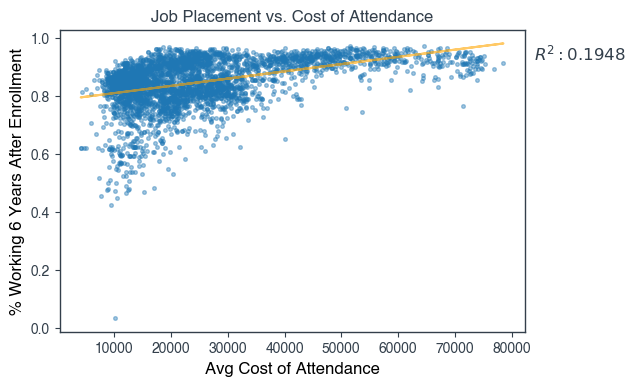

In [68]:
df = df[df.avg_cost < 100000] #remove L3Harris
x = df['avg_cost']
y = df['percent_working']
plt.scatter(x, y, s=7, alpha=0.4)

df1 = df[df.percent_working > 0.2] #remove the outlier
x = df1['avg_cost']
y = df1['percent_working'].astype(float) #originally a Decimal type
m, b = np.polyfit(x, y, 1) 
plt.plot(x, m*x + b, c='orange', alpha=0.6)

corr_matrix = np.corrcoef(x, y)
r2 = corr_matrix[0,1] ** 2
plt.annotate(f'$R^{2}: {r2:.4f}$', xy=(1.02,.9),xycoords='axes fraction',
             fontsize=fs)

plt.xlabel('Avg Cost of Attendance', fontsize=fs)
plt.ylabel('% Working 6 Years After Enrollment', fontsize=fs)
plt.title('Job Placement vs. Cost of Attendance', fontsize=fs)

Now, what about Cost of Attendance and Median Earnings?

Text(0.5, 1.0, 'Median Earnings vs. Cost of Attendance')

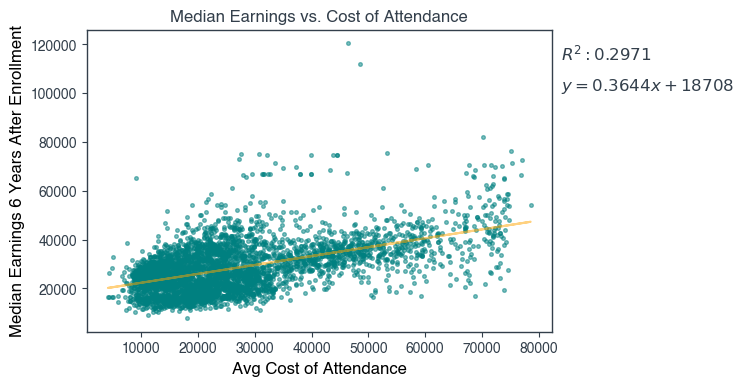

In [55]:
x = df['avg_cost']
y = df['med_earn']
plt.scatter(x, y, s=7, alpha=0.5, c='teal')

df1 = df[df.med_earn < 100000] #remove the outliers
x = df1['avg_cost']
y = df1['med_earn']
m, b = np.polyfit(x, y, 1) 
plt.plot(x, m*x + b, c='orange', alpha=0.5)

corr_matrix = np.corrcoef(x, y)
r2 = corr_matrix[0,1] ** 2
plt.annotate(f'$R^{2}: {r2:.4f}$', xy=(1.02,.9),xycoords='axes fraction',
             fontsize=fs)
plt.annotate(f'$y = {m:.4f}x + {b:.0f}$', xy=(1.02,.8),xycoords='axes fraction',
             fontsize=fs)

plt.xlabel('Avg Cost of Attendance', fontsize=fs)
plt.ylabel('Median Earnings 6 Years After Enrollment', fontsize=fs)
plt.title('Median Earnings vs. Cost of Attendance', fontsize=fs)

On the graph, there seems to be a band of high-earning schools, all w/ median earnings over 60k. Let's take a closer look at these:

In [66]:
Query3_5 = """select inst_name, median_earnings_6_years_after, avg_cost_of_attendance, avg_cost_of_attendance_program_year,
1 - number_not_working_6_years_after/(number_working_6_years_after + number_not_working_6_years_after)
as percent_working from earnings as e join costs as c on
e.unit_id = c.unit_id join universities as u on e.unit_id = u.unit_id 
where avg_cost_of_attendance is not null and median_earnings_6_years_after > 60000 order by avg_cost_of_attendance"""
mycursor.execute(Query3_5)
df = pd.DataFrame(mycursor, columns=["inst_name", "med_earn", "avg_cost", "avg_cost_py", "percent_working"])
df.head(15)

,inst_name,med_earn,avg_cost,avg_cost_py,percent_working
0,United States Merchant Marine Academy,65200,9075,None,None
1,SUNY Maritime College,61200,25905,None,0.9476
2,California State University Maritime Academy,73100,27259,None,None
3,Maine Maritime Academy,75200,27487,None,None
4,Massachusetts Maritime Academy,66300,27858,None,None
5,Georgia Institute of Technology-Main Campus,65500,28454,None,0.9500
6,Chamberlain University-Texas,67100,29476,None,0.9372
7,St Paul's School of Nursing-Staten Island,75100,30687,None,None
8,Chamberlain University-Florida,67100,31166,None,0.9372
9,Chamberlain University-Ohio,67100,31488,None,0.9372


Let's take a look at a few extremes

Highest Earnings:

In [59]:
Query4 = """select inst_name, median_earnings_6_years_after, avg_cost_of_attendance, avg_cost_of_attendance_program_year,
1 - number_not_working_6_years_after/(number_working_6_years_after + number_not_working_6_years_after)
as percent_working from earnings as e join costs as c on
e.unit_id = c.unit_id join universities as u on e.unit_id = u.unit_id order by median_earnings_6_years_after desc"""
mycursor.execute(Query4)
df = pd.DataFrame(mycursor, columns=["inst_name", "med_earn", "avg_cost", "avg_cost_py", "percent_working"])
df.head(15)

,inst_name,med_earn,avg_cost,avg_cost_py,percent_working
0,Philadelphia College of Osteopathic Medicine,127400.0,NaN,NaN,None
1,University of Health Sciences and Pharmacy in ...,120400.0,46470.0,NaN,None
2,Albany College of Pharmacy and Health Sciences,112100.0,48545.0,NaN,None
3,Western University of Health Sciences,108100.0,NaN,NaN,None
4,Salus University,100400.0,NaN,NaN,None
5,Samuel Merritt University,100100.0,NaN,NaN,None
6,Southern College of Optometry,99300.0,NaN,NaN,None
7,A T Still University of Health Sciences,99000.0,NaN,NaN,None
8,Illinois College of Optometry,96000.0,NaN,NaN,None
9,University of California-San Francisco,95400.0,NaN,NaN,None


These mostly seem to be medical-oriented schools. They don't have average cost statistics though.

Low earnings with highest costs:

In [69]:
Query5 = """select inst_name, median_earnings_6_years_after, avg_cost_of_attendance, avg_cost_of_attendance_program_year,
1 - number_not_working_6_years_after/(number_working_6_years_after + number_not_working_6_years_after)
as percent_working from earnings as e join costs as c on
e.unit_id = c.unit_id join universities as u on e.unit_id = u.unit_id 
where median_earnings_6_years_after < 30000 order by avg_cost_of_attendance desc"""
mycursor.execute(Query5)
df = pd.DataFrame(mycursor, columns=["inst_name", "med_earn", "avg_cost", "avg_cost_py", "percent_working"])
df.head(15)

,inst_name,med_earn,avg_cost,avg_cost_py,percent_working
0,Oberlin College,27400,74636.0,NaN,0.8992
1,Landmark College,19300,73821.0,NaN,0.8556
2,Bennington College,24100,73133.0,NaN,None
3,Bard College,28800,72789.0,NaN,0.8811
4,Sarah Lawrence College,28900,72469.0,NaN,0.8877
5,San Francisco Art Institute,26500,71486.0,NaN,0.7651
6,California Institute of the Arts,26900,71382.0,NaN,0.8665
7,Bard College at Simon's Rock,21700,70488.0,NaN,None
8,Manhattan School of Music,16800,68686.0,NaN,None
9,St. John's College,22300,67916.0,NaN,None


Mostly liberal arts/arts schools.

# How do different types of institutions compare? 

# How do different areas of study compare?



Query2 = """SELECT Q22.season_number, COUNT(*) AS Number_of_episodes, AVG(Q22.average_rating) AS Average_of_ep_average_ratings
FROM Q22
GROUP BY Q22.season_number
ORDER BY Q22.season_number;"""

In [16]:
mycursor.execute(Query2)

ProgrammingError: 1146 (42S02): Table 'imdb.q22' doesn't exist

In [16]:
data = mycursor.fetchall()

In [17]:
df2 = pd.DataFrame(data,columns=['season_no','no_of_eps','avg_of_avg_ratings'])

In [18]:
df2.head()

,season_no,no_of_eps,avg_of_avg_ratings
0,1,24,7.812500
1,2,25,8.008000
2,3,24,8.191667
3,4,24,8.170833
4,5,20,8.295000


In [19]:
df2['total_eps_so_far'] = df2['no_of_eps'].cumsum()

In [20]:
df2.head()

,season_no,no_of_eps,avg_of_avg_ratings,total_eps_so_far
0,1,24,7.812500,24
1,2,25,8.008000,49
2,3,24,8.191667,73
3,4,24,8.170833,97
4,5,20,8.295000,117


We will plot the results of the above two queries to illustrate the average ratings of The X-files episodes.

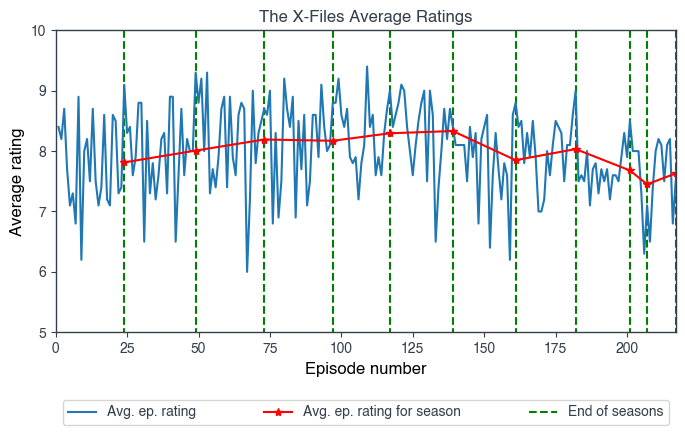

In [21]:
fig = plt.figure(figsize=(8,4))
ax = plt.gca()

# Plot average ep. rating
ax.plot(df.index+1,df.avg_rating,label='Avg. ep. rating')

# Plot the average of the average ep. rating for each season
ax.plot(df2['total_eps_so_far'],df2['avg_of_avg_ratings'],linestyle='-',marker='*',color='red',label='Avg. ep. rating for season')

# Draw vertical lines marking the end of a season 
ax.vlines(df2['total_eps_so_far'], ymin=0, ymax=10,linestyle='--', colors='g',label='End of seasons')

# Limits
ax.set_ylim([5,10])
ax.set_xlim([0,df2['total_eps_so_far'].iloc[-1]])

# Labels
plt.xlabel('Episode number',fontsize=fs)
plt.ylabel('Average rating',fontsize=fs)
plt.title('The X-Files Average Ratings',fontsize=fs)

# Legend 
ax.legend(loc='lower left',mode='expand',ncol=3,bbox_to_anchor=(0,-0.33,1,1))

# Save it
plt.savefig(os.path.join(img_directory,'The_X-Files_ratings.png'), bbox_inches="tight")

## Genres 

### What genres are there? How many movies are there in each genre?

In [22]:
Query3 ="""SELECT G.genre, COUNT(G.genre) AS Count
FROM Title_genres AS G, Titles AS T
WHERE T.title_id = G.title_id
AND T.title_type = 'movie'
GROUP BY genre
ORDER BY Count DESC;"""

In [23]:
mycursor.execute(Query3)

In [24]:
data = mycursor.fetchall()

In [25]:
df3 = pd.DataFrame(data,columns=['Genre','No. of movies'])

In [26]:
df3.head(9)

,Genre,No. of movies
0,Drama,189317
1,Documentary,100157
2,Comedy,92269
3,Action,45338
4,Romance,39742
5,Thriller,34563
6,Crime,30647
7,Horror,27841
8,Adventure,24340


In [27]:
genres = df3.Genre

We will visualise this using a horizontal bar chart

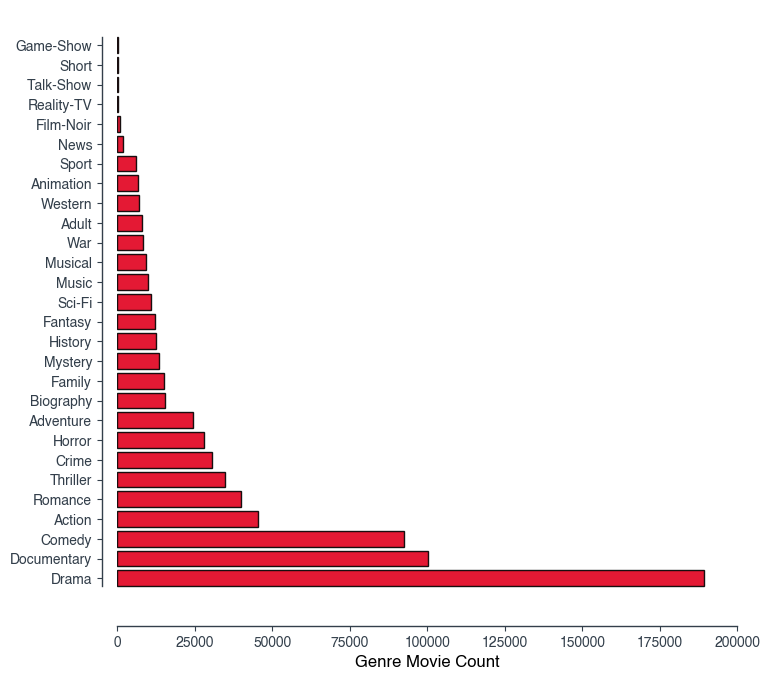

In [28]:
fig = plt.figure(figsize=(8,8))

# Bar chart
plt.barh(df3['Genre'],df3['No. of movies'], align='center',
         alpha=0.9,color='#E1001E',edgecolor='black')

# Limit
plt.xlim([0,200000])

# X label
plt.xlabel('Genre Movie Count',fontsize=fs)

# Change the style of the axis spines
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

# Set the spines position
ax.spines['bottom'].set_position(('axes', -0.02))
ax.spines['left'].set_position(('axes', -0.025))

# Save it
plt.savefig(os.path.join(img_directory,'Genre_movie_count.png'), bbox_inches="tight")

### How many movies are made in each genre each year?

In [29]:
Query4 ="""SELECT T.start_year, G.genre, COUNT(DISTINCT T.title_id) AS Number_of_movies
FROM Titles AS T, Title_genres AS G
WHERE T.title_id = G.title_id
AND T.title_type = 'movie'
AND T.start_year <= 2019
GROUP BY T.start_year, G.genre
ORDER BY T.start_year DESC, G.genre ASC;"""

In [30]:
mycursor.execute(Query4) 

In [31]:
data = mycursor.fetchall()

In [32]:
df4 = pd.DataFrame(data,columns=['Year','Genre','Number of movies'])

In [33]:
df4.head()

,Year,Genre,Number of movies
0,2019,Action,1061
1,2019,Adult,66
2,2019,Adventure,505
3,2019,Animation,353
4,2019,Biography,442


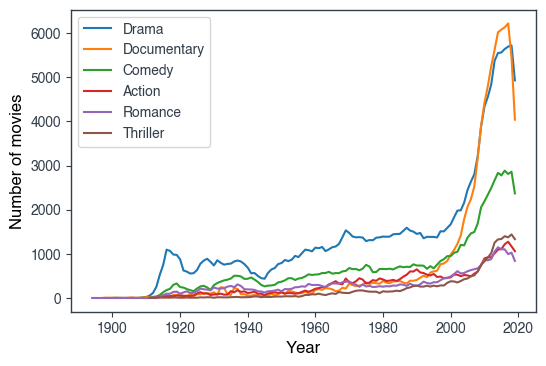

In [34]:
fig = plt.figure(figsize=(6,4))

# For each genre g in genres (only consider the top 6 genres)
for g in genres[:6]:
    
    # Data for a particular genre 
    g_df = df4[df4.Genre.str.contains(g)]

    # Plot number of movies for this genre vs year 
    plt.plot(g_df['Year'],g_df['Number of movies'],label=g)

# Legend
plt.legend()

# Labels
plt.xlabel('Year',fontsize=fs)
plt.ylabel('Number of movies',fontsize=fs)

# Save it
plt.savefig(os.path.join(img_directory,'Genre_movie_count_vs_year.png'), bbox_inches="tight")

### How do the average ages of leading actors and actresses compare in each genre?

We limit ourselves to movies between 1919 and 2019. To determine the age of an actor/actress when the movie was being made the title start year and the birth year of the person must both be non-NULL. If either of these are NULL, then that entry is neglected.

First we create an intermediate table `Leading_people` with 'year','title_id','job_category', and 'ordering' data. We then query this table to combine this with 'age' and 'genre' information.

In [35]:
mycursor.execute("""DROP TABLE IF EXISTS Leading_people;""")

In [36]:
Query5 = """CREATE TABLE  Leading_people
AS SELECT T.start_year, T.title_id, P.job_category, MIN(P.ordering) AS ordering
FROM Titles AS T, Principals AS P, Names_ AS N
WHERE T.title_id = P.title_id
AND P.job_category IN ('actor','actress')
AND T.title_type = 'movie'
AND T.start_year IS NOT NULL
AND N.birth_year IS NOT NULL
AND N.name_id = P.name_id
AND T.start_year BETWEEN 1919 AND 2019 
GROUP BY T.title_id, P.job_category
ORDER BY T.start_year, T.title_id;"""

In [37]:
mycursor.execute(Query5)

In [38]:
Query6 = """SELECT L.*, T.start_year - N.birth_year AS age, G.genre
FROM Leading_people AS L, Names_ AS N, Titles AS T, Principals AS P, Title_genres AS G
WHERE L.title_id = T.title_id
AND P.title_id = L.title_id
AND P.name_id = N.name_id
AND P.ordering = L.ordering
AND T.title_id = G.title_id ;"""

In [39]:
mycursor.execute(Query6)

In [40]:
data = mycursor.fetchall()

In [41]:
df6 = pd.DataFrame(data,columns=['year','title_id','job_category','ordering','age','genre'])

In [42]:
df6.head()

,year,title_id,job_category,ordering,age,genre
0,1919,tt0002423,actress,1,22,Biography
1,1919,tt0002423,actress,1,22,Drama
2,1919,tt0002423,actress,1,22,Romance
3,1919,tt0002423,actor,2,35,Biography
4,1919,tt0002423,actor,2,35,Drama


Let's group by year, job_category (actor/actress, i.e., gender) and also genre using pandas' groupby function

In [43]:
df_ages = df6[['year','job_category','genre','age']].groupby(by=['year','job_category','genre'])

We define two functions which will be pass to the aggregrate function. These functions will be used to calculate the first and third quartile.

In [44]:
def Q1(x):
    """The first quartile = 0.25 quantile = 25 th percentile."""
    return x.quantile(q=0.25)

In [45]:
def Q3(x):
    """The third quartile = 0.75 quantile = 75 th percentile."""
    return x.quantile(q=0.75)

In [46]:
df = df_ages.agg({'age': ['mean','median', Q1,Q3]}).reset_index()

Rename columns 

In [47]:
df.columns = ['year','job_category','genre','mean','median','Q1','Q3']

In [48]:
df.head()

,year,job_category,genre,mean,median,Q1,Q3
0,1919,actor,Action,37.309091,34.0,30.50,43.00
1,1919,actor,Adventure,36.416667,35.0,31.75,42.00
2,1919,actor,Biography,46.250000,47.0,38.00,55.25
3,1919,actor,Comedy,36.203175,34.0,30.00,41.00
4,1919,actor,Crime,37.457746,36.0,30.00,43.00


In [49]:
def genre_age_plot(g,df):
    """Plotting function for individual plot."""
    
    # Men
    genre_actors = df[(df.genre.str.contains(g)) & (df.job_category.str.contains('actor'))][['year','mean','Q1','Q3']]
    
    # Women 
    genre_actresses = df[(df.genre.str.contains(g)) & (df.job_category.str.contains('actress'))][['year','mean','Q1','Q3']]
    
    # Plot mean 
    plt.plot(genre_actors['year'],genre_actors['mean'],color='blue')
    
    # Fill area between first and third quartiles 
    plt.fill_between(genre_actors['year'], genre_actors['Q1'], 
                     genre_actors['Q3'], facecolor='blue', alpha=0.2,label='actor')

    # Plot mean 
    plt.plot(genre_actresses['year'],genre_actresses['mean'],color='red')
    
    # Fill area between first and third quartiles 
    plt.fill_between(genre_actresses['year'], genre_actresses['Q1'], 
                     genre_actresses['Q3'], facecolor='red', alpha=0.2,label='actress')

    # labels 
    plt.xlabel('Year',fontsize=fs)
    plt.ylabel('Age of lead actor/actress',fontsize=fs)
    plt.title(g,fontsize=fs)
    
    # Legend 
    plt.legend(loc='upper left')

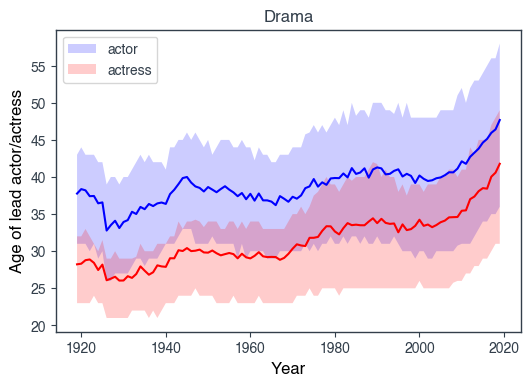

In [50]:
genre_age_plot('Drama',df)

# Save it
plt.savefig(os.path.join(img_directory,'Drama_average_age_gender.png'), bbox_inches="tight")

In [51]:
def genre_age_plot_ax(ax,g,df):
    """Plotting function to used for subplots."""
    
    # Men 
    genre_actors = df[(df.genre.str.contains(g)) & (df.job_category.str.contains('actor'))][['year','mean','Q1','Q3']]
    
    # Women 
    genre_actresses = df[(df.genre.str.contains(g)) & (df.job_category.str.contains('actress'))][['year','mean','Q1','Q3']]
    
    # Plot mean 
    ax.plot(genre_actors['year'],genre_actors['mean'],color='blue')
    
    # Fill area between first and third quartiles 
    ax.fill_between(genre_actors['year'], genre_actors['Q1'], 
                     genre_actors['Q3'], facecolor='blue', alpha=0.2,label='actor')

    # Plot mean 
    ax.plot(genre_actresses['year'],genre_actresses['mean'],color='red')
    
    # Fill area between first and third quartiles 
    ax.fill_between(genre_actresses['year'], genre_actresses['Q1'], 
                     genre_actresses['Q3'], facecolor='red', alpha=0.2,label='actress')

    # Genre title 
    ax.set_title(g,fontsize=fs)


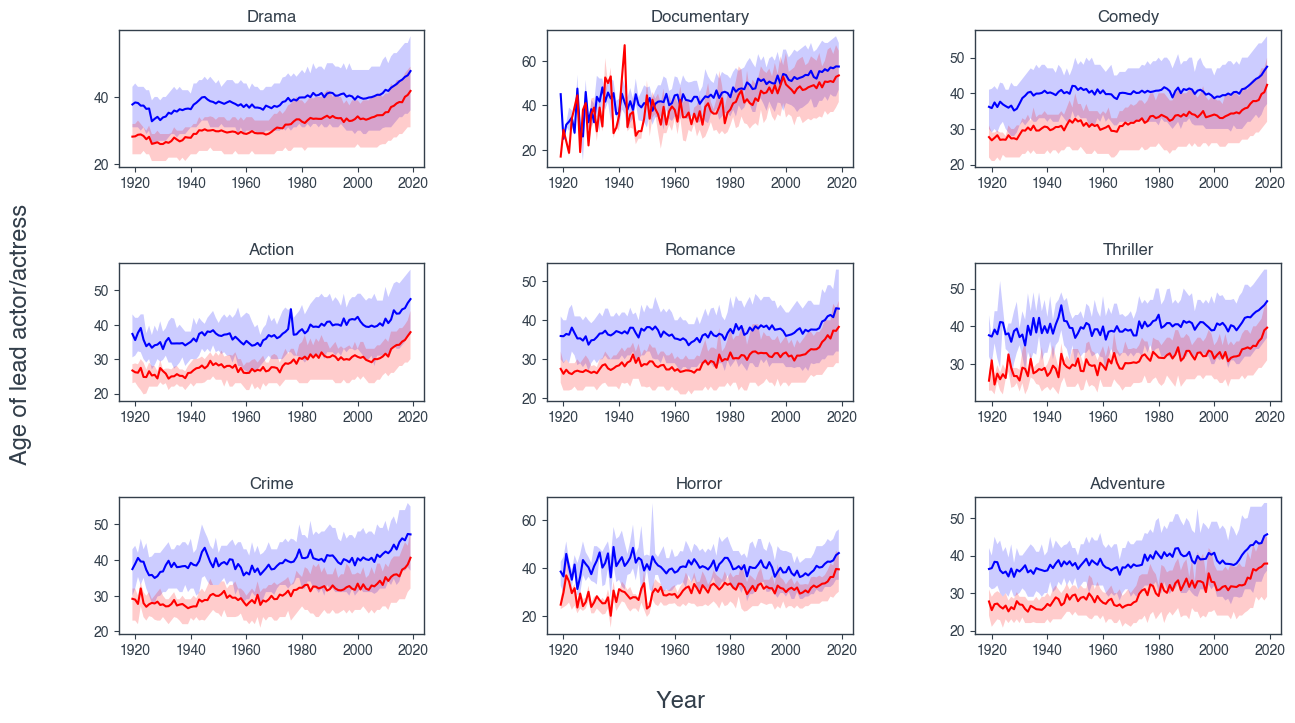

In [52]:
fig, axs = plt.subplots(3,3,figsize=(15, 8))
fig.subplots_adjust(hspace=0.7, wspace=0.4)

# Consider only the top 9 genres 
g = genres[:9] 

axs = axs.ravel()

for i in range(9): 
    genre_age_plot_ax(axs[i],g[i],df)
    
# Set common labels
fig.text(0.5, 0.04, 'Year', ha='center', va='center',fontsize=fs+5)
fig.text(0.06, 0.5, 'Age of lead actor/actress', ha='center', va='center', rotation='vertical',fontsize=fs+5)

# Save it
plt.savefig(os.path.join(img_directory,'Top_9_genres_average_age_gender.png'), bbox_inches="tight")

### What is a typical runtime for movies in each genre?

In [53]:
Query7 ="""SELECT G.genre, T.runtime_minutes 
FROM Titles AS T, Title_genres AS G 
WHERE T.runtime_minutes IS NOT NULL
AND T.title_type = 'movie'
AND T.title_id = G.title_id; """

In [54]:
mycursor.execute(Query7)

In [55]:
data = mycursor.fetchall()

In [56]:
df7 = pd.DataFrame(data,columns=['genre','runtime_minutes'])

In [57]:
df7.head()

,genre,runtime_minutes
0,Romance,45
1,Documentary,20
2,News,20
3,Sport,20
4,Biography,70


Some titles have extremely large and unrelistic values, to ignore these we introduce a cutoff for the runtime_minutes.

In [58]:
cutoff = 300 

Histogram using matplotlib

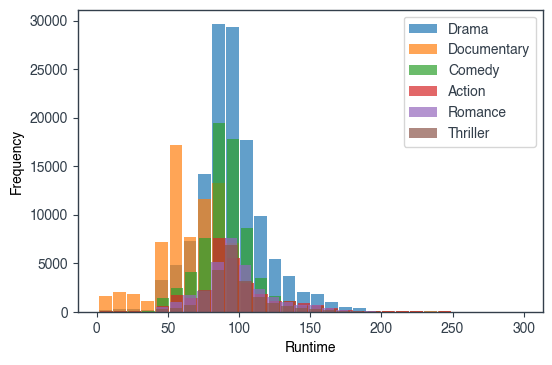

In [59]:
fig = plt.figure(figsize=(6,4))

# Only consider the top 6 genres 
for g in genres[:6]:

    # Series contain genre g runtime data 
    sg = df7[df7.genre.str.match(g) & (df7['runtime_minutes'] < cutoff)]['runtime_minutes']

    # Plot histogram for g using matplotlib
    n, bins, patches = plt.hist(sg,bins=30,alpha=0.7,rwidth=0.9,label=g)

# Labels 
plt.xlabel('Runtime')
plt.ylabel('Frequency')

# Legend 
plt.legend()

Matplotlib via pandas

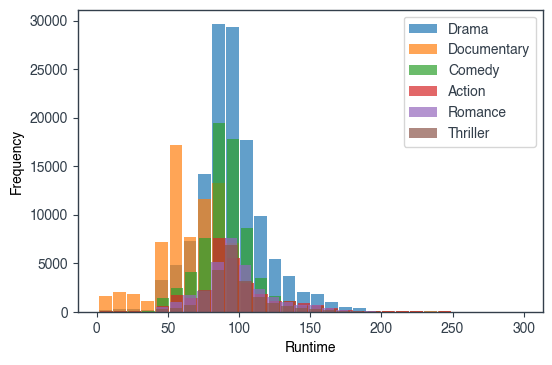

In [60]:
fig = plt.figure(figsize=(6,4))

# Only consider the top 6 genres 
for g in genres[:6]:

    # Series contain genre g runtime data 
    sg = df7[df7.genre.str.match(g) & (df7['runtime_minutes'] < cutoff)]['runtime_minutes']

    # Plot histogram for g using pandas/matplotlib 
    sg.plot.hist(grid=False, bins=30, rwidth=0.9,alpha=0.7,label=g)

# Label     
plt.xlabel('Runtime')

# Legend 
plt.legend()

# Save it
plt.savefig(os.path.join(img_directory,'Top_6_genres_runtime_hist.png'), bbox_inches="tight")

## Close database 

In [61]:
mycursor.close()

True

In [62]:
mydb.close()